<a href="https://colab.research.google.com/github/Justin-Jonany/SciDigest/blob/main/2_scidigest_model_training_mini_20k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SciDigest**
With the growth of many fields, more papers are published annually. Researchers need to find sources for their research, so abstracts are really helpful. However, reading through hundreds of unstructured abstracts is time-consuming and irritating.

**SciDigest** is a deep learning model that aims to help people, especially researchers, to digest abstracts better. This model receives abstracts as inputs and turn it into a structured abstract.

**SciDigest** will be trained on [PubMed 200k and 20k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct).

Some of the model architecture will be referenced and based on:
* [Paper 1](https://arxiv.org/pdf/1710.06071.pdf)
* [Paper 2](https://arxiv.org/pdf/1612.05251.pdf)

**Note:**
Through this notebook and other notebooks, these papers will be referred as **[Paper 1](https://arxiv.org/pdf/1710.06071.pdf)** and **[Paper 2](https://arxiv.org/pdf/1612.05251.pdf)**

## Goal
The goal of this project:
1. Replicate the model architecture in **Paper 2**
2. Beat the F1-Score of the model in **Paper 1**, that is **91.6**


## Notebook Goal
This notebook aims to:
1. Create a model that fulfills **Goal 1**

**This notebook will only be trained on 20% of 20k dataset, hence why mini**


In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1237sz70ncTkzRxKoIufBSh3Q-xkUcuHt/preview" width="640" height="480" allow="autoplay"></iframe>

Figure 1 of Paper 2, the model I'm trying to repliate

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pickle
import string

## Helper Function

In [ ]:
def get_data(data_path, data, data_types, to_list=False):
  '''
  Returns a list of dataframes from the directory data_path + data for all
  types of data (train/val/test) listed in data_types. If to_list is True,
  it will be returned as a list, otherwise it's a DataFrame.
  '''

  if to_list:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0)['0'].tolist() for data_type in data_types]
  else:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0) for data_type in data_types]

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def predict_data(model, data):
  '''
  Predicts data with model and returns the predicted class

  Args:
    model: a machine learning model
    data: batched dataset
  Returns:
    prediction: predicted class
  '''
  prediction = model.predict(data, verbose=0)
  prediction = tf.argmax(prediction, axis=1)
  return prediction

## Loading Data

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/data'
datas = os.listdir(data_path)
datas

['general',
 'sentences',
 'sentences_chars',
 'ohe_labels',
 'le_labels',
 'line_numbers',
 'total_lines',
 'general_200k',
 'sentences_200k',
 'sentences_chars_200k',
 'le_labels_200k',
 'line_numbers_200k',
 'total_lines_200k',
 'ohe_labels_200k']

In [ ]:
data_types = ['train', 'val']
general = get_data(data_path, 'general', data_types)
sentences = get_data(data_path, 'sentences', data_types, to_list=True)
sentences_chars = get_data(data_path, 'sentences_chars', data_types)
ohe_labels = get_data(data_path, 'ohe_labels', data_types)
le_labels = get_data(data_path, 'le_labels', data_types, to_list=True)
line_numbers = get_data(data_path, 'line_numbers', data_types)
total_lines = get_data(data_path, 'total_lines', data_types)

In [ ]:
TRAIN = 0 # index of the train data
VAL = 1 # index of the validation data

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/models/'

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(general[0].target.unique())
class_names = general[0].target.unique()

num_classes, class_names

(5,
 array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
       dtype=object))

Models
* Model 0 (Baseline Model): Multinomial Naive Bayes
* Model 1: Conv1D with token embeddings
* Model 2: Feature extraction with pretrained token embeddings
* Model 3: Conv1D with character embeddings
* Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)
* Model 5: Pretrained token embeddings + character embeddings + positional embeddings (**my implementation of Paper 2's model**)

Each model will progress to reach Paper 2's model, but it's not exactly the same, there are some changes that I think would improve it. For example:
1. Using Adaptive Moment Estimation (Adam) optimizer instead of Stochastic Gradient Descent (SGD)
2. Using Universal Sentence Encoder (USE) instead of GloVe as the embedding layer



## 0. Model 0: Baseline Model
Multinomail Naive Bayes

In [ ]:
# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=sentences[TRAIN], y=le_labels[TRAIN])

KeyboardInterrupt: ignored

In [ ]:
filename = MODEL_PATH + 'model_0.sav'

In [ ]:
pickle.dump(model_0, open(filename, 'wb'))

In [ ]:
model_0 = pickle.load(open(filename, 'rb'))

In [ ]:
model_0_results = calculate_results(y_true=le_labels[VAL], y_pred=model_0.predict(sentences[1]))
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

> **IMPORTANT NOTE:**
<br>
To save time and computing power limitations, all fitting for deep learning models will only be on **20% of training data** for now.

## 1. Model 1: Conv1D with token embeddings

### Preparing Datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((sentences[TRAIN], ohe_labels[TRAIN])).batch(32).prefetch(tf.data.AUTOTUNE).cache()
valid_dataset = tf.data.Dataset.from_tensor_slices((sentences[VAL], ohe_labels[VAL])).batch(32).prefetch(tf.data.AUTOTUNE).cache()

### Creating Text Vectorization Layer

In [ ]:
# How many words are in our vocab? (taken from table 1 of Paper 2)
max_tokens = 68000

We need to decide the length of the vectorized sequence. Let's decide based on the 95% percentile of the sentence lengths.

In [ ]:
sent_lens = [len(sentence.split()) for sentence in sentences[TRAIN]]
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                            output_mode='int',
                                            output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(sentences[TRAIN])

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f"Most common woords in the vocav: {rct_20k_text_vocab[:5]}")
print(f"Least common woords in the vocav: {rct_20k_text_vocab[:-5]}")

Number of words in vocab: 64841
Most common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of']
Least common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased',

### Creating Text Embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different number of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

### Creating, Compiling, and Fitting Model

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x) # create output layer

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.2*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)), # only validation on 10% of batches
                              )

Epoch 1/5
1125/1125 [==============================] - 35s 22ms/step - loss: 0.7923 - accuracy: 0.6934 - val_loss: 0.6306 - val_accuracy: 0.7703
Epoch 2/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6024 - accuracy: 0.7825 - val_loss: 0.5806 - val_accuracy: 0.7889
Epoch 3/5
1125/1125 [==============================] - 10s 9ms/step - loss: 0.5881 - accuracy: 0.7906 - val_loss: 0.5628 - val_accuracy: 0.7985
Epoch 4/5
1125/1125 [==============================] - 8s 7ms/step - loss: 0.5526 - accuracy: 0.8053 - val_loss: 0.5343 - val_accuracy: 0.8118
Epoch 5/5
1125/1125 [==============================] - 9s 8ms/step - loss: 0.5464 - accuracy: 0.8056 - val_loss: 0.5451 - val_accuracy: 0.8009


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5374 - accuracy: 0.8091


[0.5374151468276978, 0.8091486692428589]

In [ ]:
model_1.save(MODEL_PATH + 'model_1')

In [ ]:
model_1 = tf.keras.models.load_model(MODEL_PATH + 'model_1')

In [ ]:
model_1_preds = predict_data(model_1, valid_dataset)
model_1_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.91486826426586,
 'precision': 0.8054482846262221,
 'recall': 0.8091486826426586,
 'f1': 0.8053239937900216}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## 2. Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2

The data for this model is in the same format with the one in Model 1, so there's no need to create another one.

**Note:** The paper used GloVe embedding, but for this model, the Universal Sentence Encoder (USE) will be used since it's more up to date.

### Creating, Compiling, and Fitting Model

In [ ]:
tf_hub_embedding_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2',
                                        trainable=False,
                                        name='universal_sentence_encoder')


In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=(), dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.2*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              )

Epoch 1/5
1125/1125 [==============================] - 22s 15ms/step - loss: 0.8402 - accuracy: 0.6778 - val_loss: 0.7510 - val_accuracy: 0.7071
Epoch 2/5
1125/1125 [==============================] - 18s 16ms/step - loss: 0.7311 - accuracy: 0.7210 - val_loss: 0.7049 - val_accuracy: 0.7311
Epoch 3/5
1125/1125 [==============================] - 17s 15ms/step - loss: 0.7178 - accuracy: 0.7261 - val_loss: 0.6774 - val_accuracy: 0.7387
Epoch 4/5
1125/1125 [==============================] - 17s 15ms/step - loss: 0.6771 - accuracy: 0.7438 - val_loss: 0.6494 - val_accuracy: 0.7510
Epoch 5/5
1125/1125 [==============================] - 17s 15ms/step - loss: 0.6676 - accuracy: 0.7471 - val_loss: 0.6500 - val_accuracy: 0.7563


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.6560 - accuracy: 0.7498


[0.6559603214263916, 0.7498013973236084]

In [ ]:
model_2.save(MODEL_PATH + 'model_2')

In [ ]:
model_2 = tf.keras.models.load_model(MODEL_PATH + 'model_2')

In [ ]:
model_2_preds = predict_data(model_2, valid_dataset)
model_2_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.98014034158612,
 'precision': 0.7448383872139768,
 'recall': 0.7498014034158612,
 'f1': 0.7449822474063669}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##3. Model 3: Conv1D with character embeddings

**Paper 2** states they used a combination of token and characters-level embeddings

Previously I've token-level embeddings but I'll need to do similar steps for characters if I want to use char-level embeddings.

### Preparing Datasets

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((sentences_chars[TRAIN], ohe_labels[TRAIN])).batch(32).prefetch(tf.data.AUTOTUNE).cache()
val_char_dataset = tf.data.Dataset.from_tensor_slices((sentences_chars[VAL], ohe_labels[VAL])).batch(32).prefetch(tf.data.AUTOTUNE).cache()

### Creating Character Tokenizer

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# The output of the tokenizer will be decided based on the 95% quantile of the number of characters per sentence
char_lens = [len(sentence) for sentence in sentences[TRAIN]]
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (`[UNK]`)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                          output_sequence_length=output_seq_char_len,
                                          # standardize=None, # set standardization to `None` to include punctuations
                                          name='char_vectorizer'
                                          )

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(sentences_chars[TRAIN])

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating Character-Level Embedding

In [ ]:
PAPER_2_EMBEDDING_CHAR_DIM = 25 # From Paper 2 Figure 1

char_embed = layers.Embedding(input_dim=len(char_vocab), # Number of different characters
                              output_dim=PAPER_2_EMBEDDING_CHAR_DIM,
                              mask_zero=True,
                              name='char_embed'
                              )

### Creating, Compiling, and Fitting Model

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(),
                      dtype='string')

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')


# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_45 (Dense)            (None, 

In [ ]:
# Fit the model on chars only
model_3.history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.2*len(train_char_dataset)),
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
1125/1125 [==============================] - 11s 7ms/step - loss: 1.1323 - accuracy: 0.5434 - val_loss: 0.9414 - val_accuracy: 0.6363
Epoch 2/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.8979 - accuracy: 0.6478 - val_loss: 0.8367 - val_accuracy: 0.6755
Epoch 3/5
1125/1125 [==============================] - 8s 7ms/step - loss: 0.8421 - accuracy: 0.6731 - val_loss: 0.7944 - val_accuracy: 0.6975
Epoch 4/5
1125/1125 [==============================] - 6s 5ms/step - loss: 0.8071 - accuracy: 0.6896 - val_loss: 0.7695 - val_accuracy: 0.7064
Epoch 5/5
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7894 - accuracy: 0.6943 - val_loss: 0.7668 - val_accuracy: 0.7061


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7740 - accuracy: 0.7020


[0.7740370631217957, 0.7019727230072021]

In [ ]:
model_3.save(MODEL_PATH + 'model_3')

In [ ]:
model_3 = tf.keras.models.load_model(MODEL_PATH + 'model_3')

In [ ]:
model_3_preds = predict_data(model_3, val_char_dataset)
model_3_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 70.19727260691117,
 'precision': 0.6937672797380419,
 'recall': 0.7019727260691117,
 'f1': 0.6935253743382096}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##4. Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a word-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to`model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3, similar to Figure 1 of Paper 2
5. Construct a model which takes token and character-level sequenecs as input and produces sequence label probabilities as output

### Preparing Datasets

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((sentences[0], sentences_chars[0])) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(ohe_labels[0]) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
# Combine chars and tokens into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((sentences[1], sentences_chars[1])) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(ohe_labels[1]) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

### Creating, Compiling, and Fitting Model

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(256, activation='relu')(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of the Paper 2
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation='relu')(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model
model_4 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embddings')



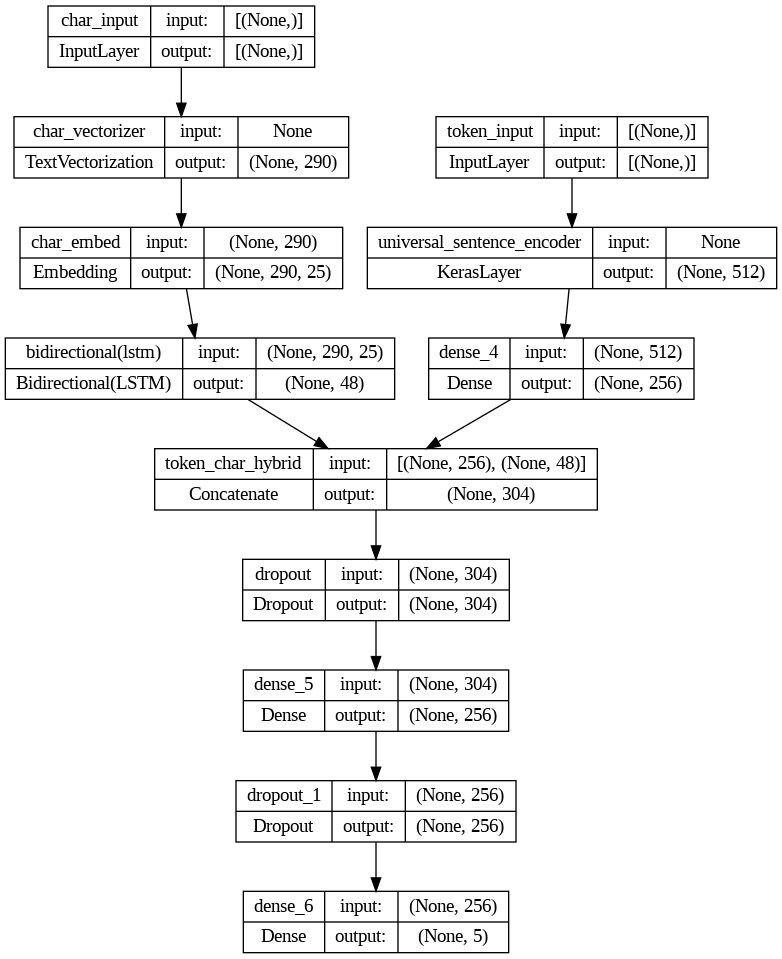

In [ ]:
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.2*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
1125/1125 [==============================] - 73s 52ms/step - loss: 0.8432 - accuracy: 0.6692 - val_loss: 0.6847 - val_accuracy: 0.7384
Epoch 2/5
1125/1125 [==============================] - 53s 47ms/step - loss: 0.7239 - accuracy: 0.7262 - val_loss: 0.6412 - val_accuracy: 0.7590
Epoch 3/5
1125/1125 [==============================] - 54s 48ms/step - loss: 0.7112 - accuracy: 0.7309 - val_loss: 0.6198 - val_accuracy: 0.7709
Epoch 4/5
1125/1125 [==============================] - 58s 51ms/step - loss: 0.6786 - accuracy: 0.7419 - val_loss: 0.6022 - val_accuracy: 0.7746
Epoch 5/5
1125/1125 [==============================] - 59s 53ms/step - loss: 0.6729 - accuracy: 0.7474 - val_loss: 0.6029 - val_accuracy: 0.7763


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6034 - accuracy: 0.7692


[0.6033821702003479, 0.7692307829856873]

In [ ]:
model_4.save(MODEL_PATH + 'model_4')

In [ ]:
model_4 = tf.keras.models.load_model(MODEL_PATH + 'model_4')

In [ ]:
model_4_preds = predict_data(model_4, val_char_token_dataset)
model_4_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.92307692307693,
 'precision': 0.7679300620630675,
 'recall': 0.7692307692307693,
 'f1': 0.7647064146783643}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##5.  Model 5: Pretrained token embeddings + character embeddings + positional embeddings Tribrid model

Note although Model 4 already looks similar with Figure 1 Paper 2, it hasn't optimized sequence label (explained in Paper 2 section 3.1.3), that part isn't showed in the figure, and I will thus implement my version of positional embedding

In [ ]:
general[0].head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


the line_number and total_lines defines the positions of each sentence

### Preparing Datasets

In [ ]:
# Create training datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers[0],
                                                                total_lines[0],
                                                                sentences[0],
                                                                sentences_chars[0]
                                                                ))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels[0])
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

# Create validation datasets (with all four kinds of input data)
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers[1],
                                                              total_lines[1],
                                                              sentences[1],
                                                              sentences_chars[1]
                                                              ))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(ohe_labels[1])
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

### Creating, Compiling, and Fitting Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(256, activation='relu')(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), # 15 since each input is one hot encoded into 15 different categories
                                  dtype=tf.float32,
                                  name='line_number_input')

# dense layer with 32 uits and relu activation
x = layers.Dense(32, activation='relu')(line_number_inputs)

# combine inputs & and ouputs into mdoel
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# 20 since each input is one hot encoded into 20 different categories
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hyrbid_embedding')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Dense(256, activation='relu')(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
z = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined tokena and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])


# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   

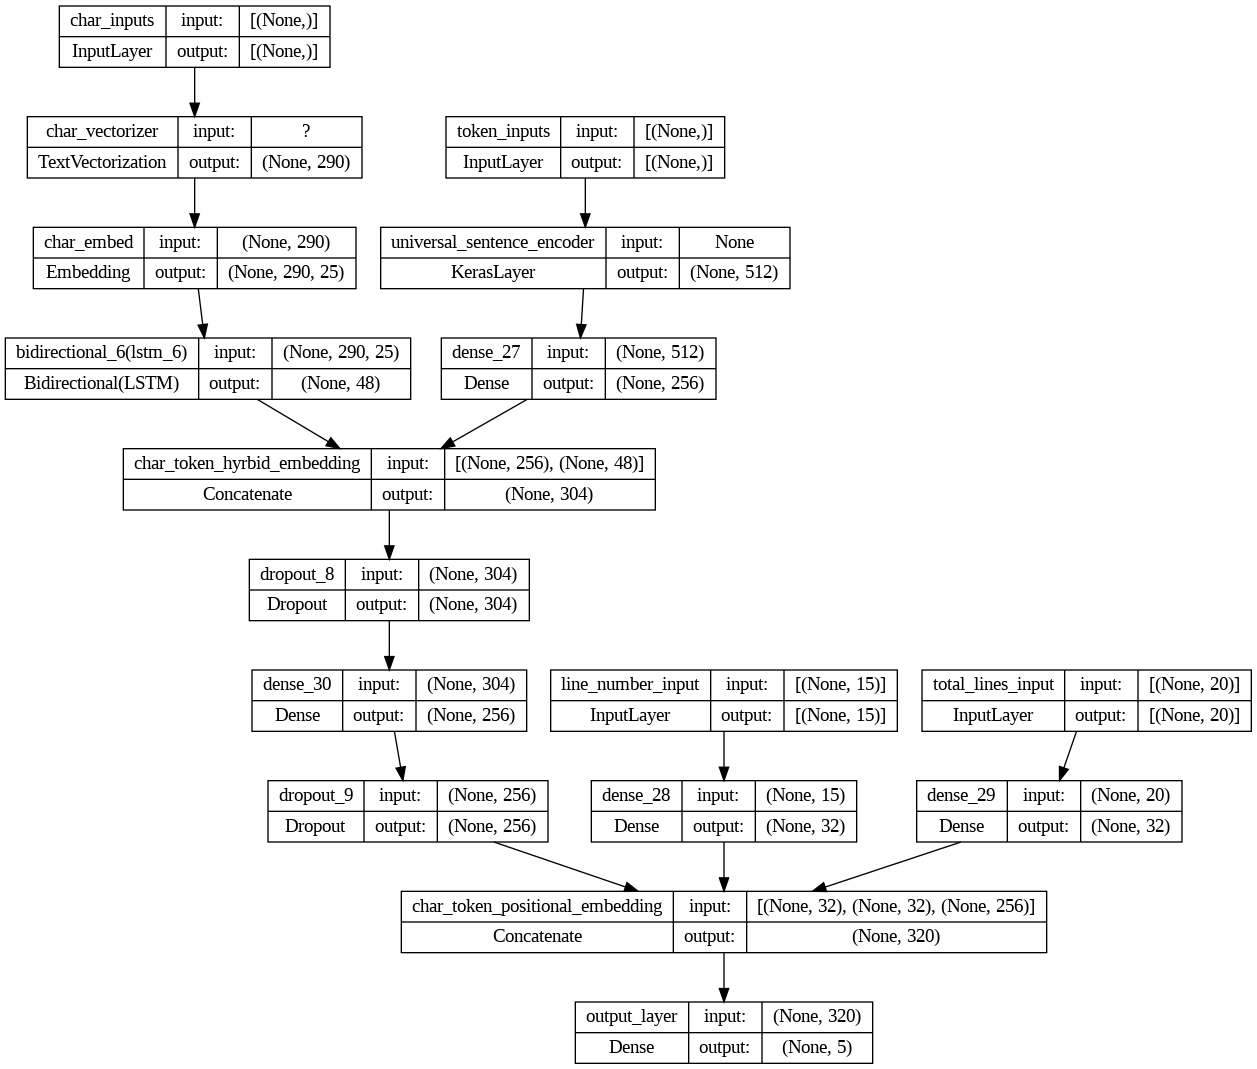

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit our trbrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.2*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset))
                              )

Epoch 1/5
1125/1125 [==============================] - 69s 52ms/step - loss: 1.0469 - accuracy: 0.7607 - val_loss: 0.9522 - val_accuracy: 0.8268
Epoch 2/5
1125/1125 [==============================] - 54s 48ms/step - loss: 0.9598 - accuracy: 0.8200 - val_loss: 0.9354 - val_accuracy: 0.8271
Epoch 3/5
1125/1125 [==============================] - 51s 46ms/step - loss: 0.9530 - accuracy: 0.8234 - val_loss: 0.9247 - val_accuracy: 0.8411
Epoch 4/5
1125/1125 [==============================] - 58s 51ms/step - loss: 0.9412 - accuracy: 0.8310 - val_loss: 0.9128 - val_accuracy: 0.8507
Epoch 5/5
1125/1125 [==============================] - 59s 52ms/step - loss: 0.9405 - accuracy: 0.8352 - val_loss: 0.9125 - val_accuracy: 0.8461


In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9105 - accuracy: 0.8497


[0.9104852676391602, 0.8496623635292053]

In [ ]:
model_5.save(MODEL_PATH + 'model_5')

In [ ]:
model_5 = tf.keras.models.load_model(MODEL_PATH + 'model_5')

In [ ]:
model_5_preds = predict_data(model_5, val_char_token_pos_dataset)
model_5_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.96623858069641,
 'precision': 0.8512517806044062,
 'recall': 0.8496623858069641,
 'f1': 0.8459669958143955}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##6.  Model 6: Training custom token embeddings + character embeddings + positional embeddings Tribrid model

Model 6 is similar to model 5 but:
1. Use custom token embedding instead of USE
2. Add a bidirectional LSTM after the token embedding and character embedding

To concatenate the output of the token embedding and character embedding, the shape of the input need to have the same shape other than the concatenated axis. There's 2 options to set concatenations on axis=-1 or aixs =1. However, when concatenating on axis=-1 and adjusting the shapes, the training becomes too slow, and it's currently out of my capability to understand why.

Therefore, I decide to concatenate on axis=1, so to adjust the shape. The text vectorization layer and character tokenizer needs to be adjusted. The output shapes will be based on the average of the previous `output_seq_len` and `output_seq_char_len`.

In [ ]:
output_len = int((output_seq_char_len + output_seq_len) / 2)
output_len

172

### Creating Another Text Vectorization Layer

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                            output_mode='int',
                                            output_sequence_length=output_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(sentences[TRAIN])

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f"Most common woords in the vocav: {rct_20k_text_vocab[:5]}")
print(f"Least common woords in the vocav: {rct_20k_text_vocab[:-5]}")

Number of words in vocab: 64841
Most common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of']
Least common woords in the vocav: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased',

### Creating Text Embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of our vocabulary
                               output_dim=256,
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

### Creating Character Tokenizer

In [ ]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (`[UNK]`)
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                          output_sequence_length=output_len,
                                          # standardize=None, # set standardization to `None` to include punctuations
                                          name='char_vectorizer'
                                          )

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(sentences_chars[TRAIN])

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating Character-Level Embedding

In [ ]:
PAPER_2_EMBEDDING_CHAR_DIM = 25 # From Paper 2 Figure 1

char_embed = layers.Embedding(input_dim=len(char_vocab), # Number of different characters
                              output_dim=PAPER_2_EMBEDDING_CHAR_DIM,
                              mask_zero=True,
                              name='char_embed'
                              )

### Creating, Compiling, and Fitting Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype='string', name='token_inputs')
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) # create embedding
token_outputs = layers.Dense(256, activation='relu')(token_embeddings)
# Note paper 2 states that it should be 300, but 256 is used since it's a power of 2 so it's more memory efficient
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=True))(char_embeddings)
# bi-LSTM shown in Figure 1 of the paper states that the output is a length 50 vector,
#   but because it's a bidirectional lstm and it should be a power of 2 for memory efficiency
#   24 is used
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), # 15 since each input is one hot encoded into 15 different categories
                                  dtype=tf.float32,
                                  name='line_number_input')

# dense layer with 32 uits and relu activation
x = layers.Dense(32, activation='relu')(line_number_inputs)

# combine inputs & and ouputs into mdoel
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# 20 since each input is one hot encoded into 20 different categories
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hyrbid_embedding')([token_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Bidirectional(layers.LSTM(128))(combined_dropout)
# Paper states this should output length 200, so to keep memory efficency, seetting it as 256
z = layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined tokena and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])


# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_6_tribrid_embedding_model')

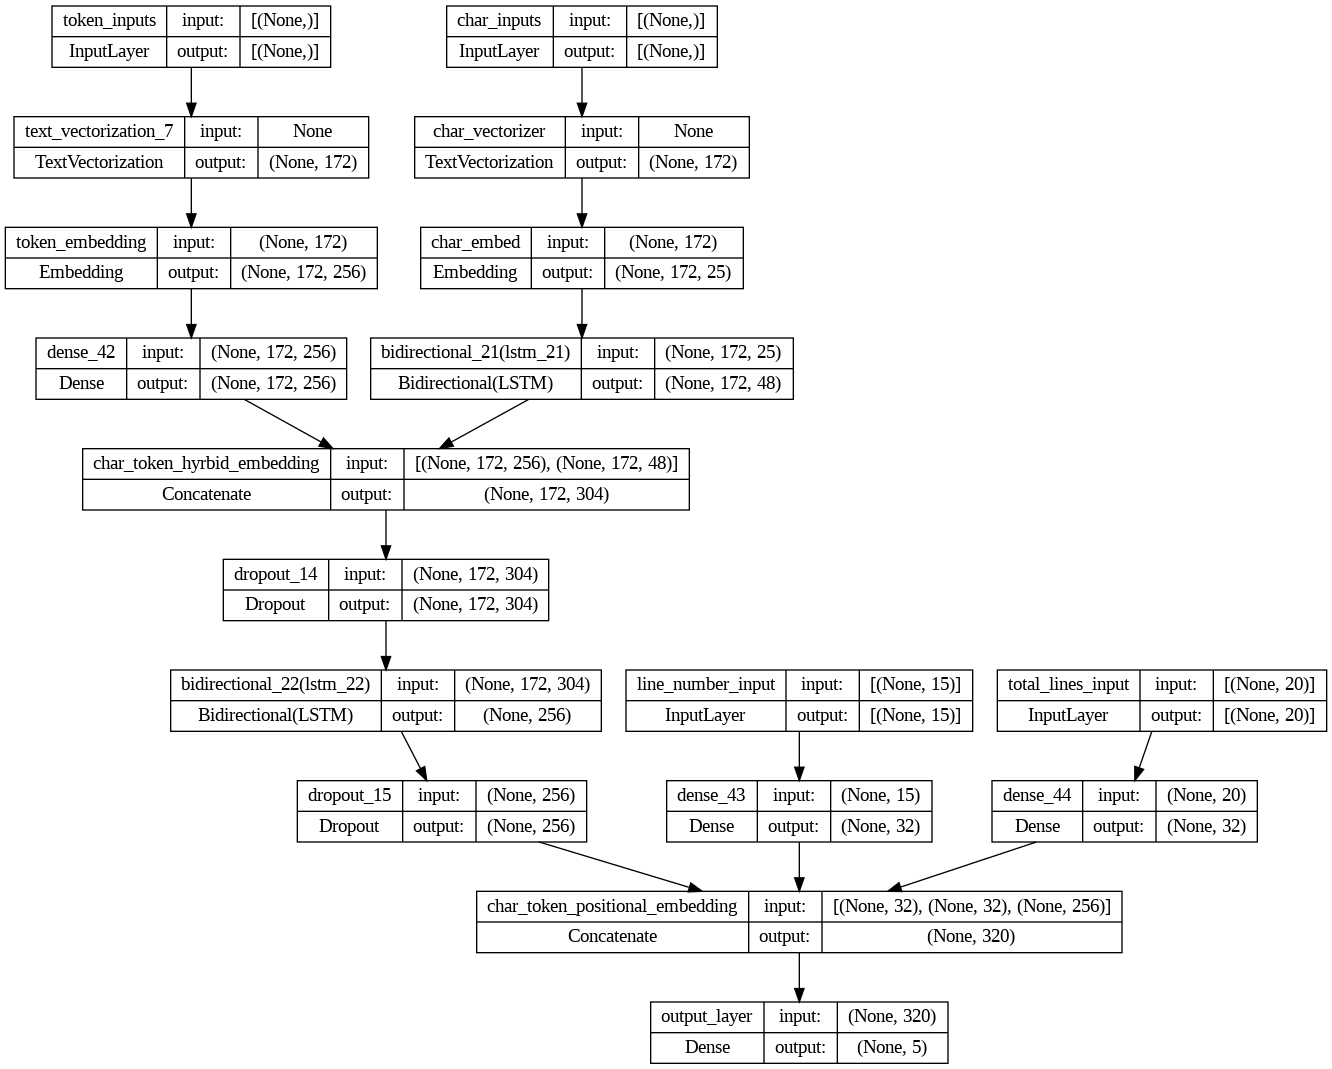

In [ ]:
plot_model(model_6, show_shapes=True, to_file='/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/best_mini_20k_model_6.png')

In [ ]:
# Compile token, char, and positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit our trbrid embedding model
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.2*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset))
                              )

Epoch 1/5
1125/1125 [==============================] - 118s 73ms/step - loss: 1.0037 - accuracy: 0.7857 - val_loss: 0.9213 - val_accuracy: 0.8328
Epoch 2/5
1125/1125 [==============================] - 58s 51ms/step - loss: 0.9128 - accuracy: 0.8487 - val_loss: 0.8972 - val_accuracy: 0.8511
Epoch 3/5
1125/1125 [==============================] - 55s 49ms/step - loss: 0.9039 - accuracy: 0.8551 - val_loss: 0.8808 - val_accuracy: 0.8674
Epoch 4/5
1125/1125 [==============================] - 62s 55ms/step - loss: 0.8904 - accuracy: 0.8612 - val_loss: 0.8734 - val_accuracy: 0.8703
Epoch 5/5
1125/1125 [==============================] - 59s 53ms/step - loss: 0.8886 - accuracy: 0.8632 - val_loss: 0.8824 - val_accuracy: 0.8624


In [ ]:
model_6.save(MODEL_PATH + 'model_6')

In [ ]:
model_6 = tf.keras.models.load_model(MODEL_PATH + 'model_6')

In [ ]:
model_6_preds = predict_data(model_6, val_char_token_pos_dataset)
model_6_results = calculate_results(y_true=le_labels[1],
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 86.82973652853171,
 'precision': 0.8711492705182088,
 'recall': 0.8682973652853171,
 'f1': 0.8654577443552515}

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_6.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.8744 - accuracy: 0.8683


[0.8743734359741211, 0.8682973384857178]

## Model Summary

In [ ]:
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
scores = pd.DataFrame({'model_0': model_0_results,
                         'model_1': model_1_results,
                         'model_2': model_2_results,
                         'model_3': model_3_results,
                         'model_4': model_4_results,
                         'model_5': model_5_results,
                         'model_6': model_6_results,
                         }, index=['accuracy', 'precision', 'recall', 'f1'])
scores = scores.T
scores

,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,80.914868,0.805448,0.809149,0.805324
model_2,74.980140,0.744838,0.749801,0.744982
model_3,70.197273,0.693767,0.701973,0.693525
model_4,76.923077,0.767930,0.769231,0.764706
model_5,84.966239,0.851252,0.849662,0.845967
model_6,86.829737,0.871149,0.868297,0.865458


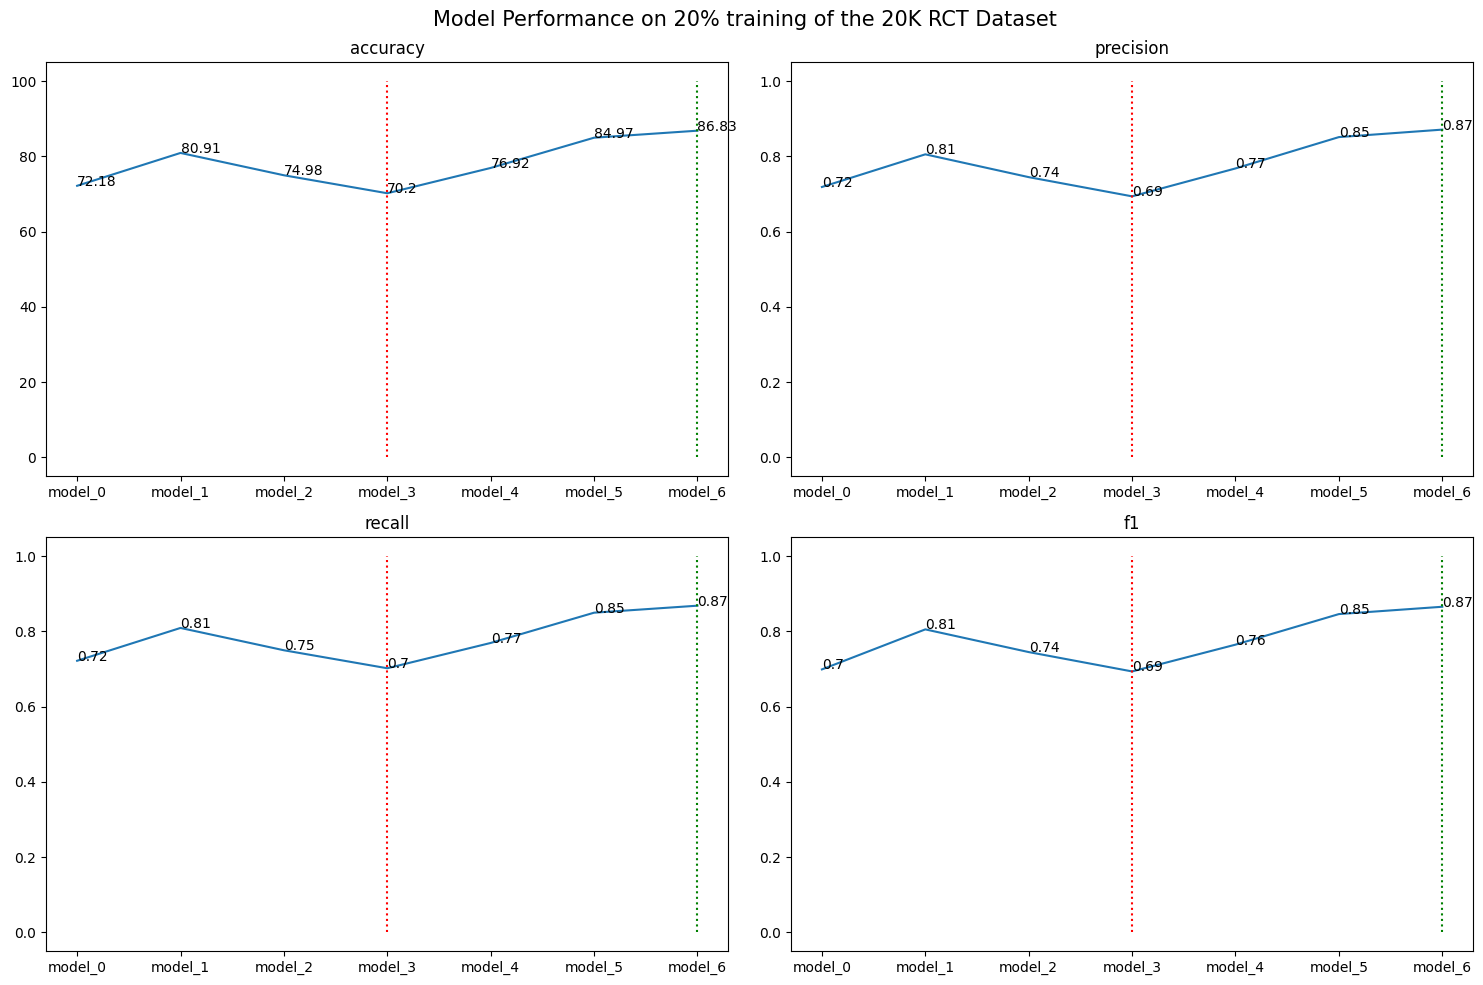

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, index in enumerate(scores.columns):
  plt.subplot(2, 2, 1 + i)
  plt.plot(scores[index])
  plt.title(index)
  if index == 'accuracy':
    plt.vlines(scores.index[scores[index].argmax()], 0, 100, color='green', linestyles='dotted')
    plt.vlines(scores.index[scores[index].argmin()], 0, 100, color='red', linestyles='dotted')
  else:
    plt.vlines(scores.index[scores[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(scores.index[scores[index].argmin()], 0, 1, color='red', linestyles='dotted')
  for i in range(len(scores[index])):
    plt.annotate(np.round(scores[index][i], 2), (i, scores[index][i]), )
  # plt.annotate(scores[index], (index, scores[index]))


fig.suptitle('Model Performance on 20% training of the 20K RCT Dataset', size=15)
fig.tight_layout()
plt.savefig(FIG_PATH + 'model_performance.png')
plt.show()

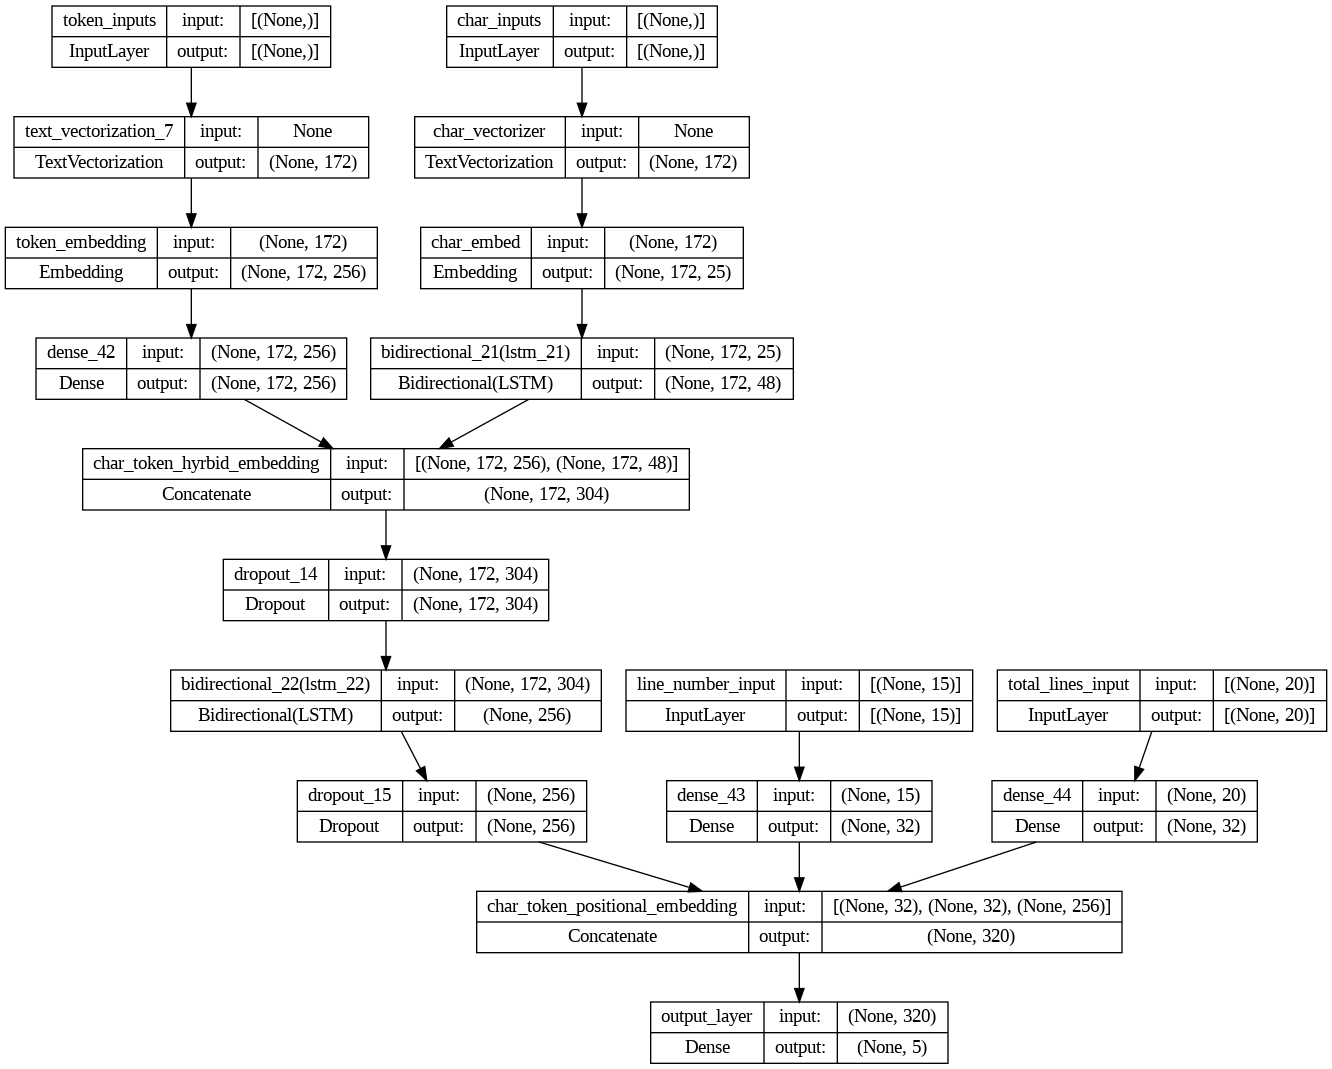

In [ ]:
plot_model(model_6, show_shapes=True, to_file='/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/best_mini_20k_model_6.png')

This is my implementation of the paper's notebook with some modifications:
1. Custom-trained token vectorization and embedding layer
2. Optimization algorithm, Adam instead of SGD
3. Number of hidden units, and some shapes that are not specified are determined by myself immediately


In [ ]:
fig.savefig("/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/model_performance_mini_20k.png")